In [1]:
# Imports math library
import numpy as np

# Imports plotting library
import matplotlib.pyplot as plt

import random

# Test convex polygon generation

In [2]:
class Point: 

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def distance(self, p):
        return np.sqrt((p.x - self.x)**2 + (p.y - self.y)**2)
    
    def __str__(self):
        return f"Point(x={self.x}, y={self.y})"
    
class Segment:

    def __init__(self, start, end):
        self.start = start
        self.end = end

    def normal(self):
        # Calculate the normal vector of the segment
        return Point(-(self.end.y - self.start.y), self.end.x - self.start.x)

    def project(self, axis):
        # Project the segment onto an axis and return the min and max values
        min_proj = min(self.start.x * axis.x + self.start.y * axis.y,
                       self.end.x * axis.x + self.end.y * axis.y)
        max_proj = max(self.start.x * axis.x + self.start.y * axis.y,
                       self.end.x * axis.x + self.end.y * axis.y)
        return min_proj, max_proj

class Polygon:

    def __init__(self, points):
        """
        :param points: a list of 2-dimensional vectors.
        """

        # Deep copy of the points array. While making the copy we can
        # find the centroid of the polygon

        self.points = []
        for point in points:
            if isinstance(point, Point):
                self.points.append(Point(point.x, point.y))  # copy it
            elif isinstance(point, tuple):
                self.points.append(Point(point[0], point[1]))
            else:
                raise ValueError(f'Invalid object {point}')
            
        self.angle = 0
            
    def __len__(self):
        return len(self.points)
    
    def __str__(self):
        point_str = ', '.join(str(point) for point in self.points)
        return f"Polygon(points=[{point_str}])"

    def translate(self, offset_x, offset_y):

        for point in self.points:
            point.x = point.x + offset_x
            point.y = point.y + offset_y

    def rotate(self, angle_degrees):
        
        center_x, center_y = self.find_center()
        angle_radians = np.deg2rad(angle_degrees)
        self.angle += angle_degrees

        # Apply rotation to each point
        for point in self.points:
            # Translate the point to the origin (center) of rotation
            translated_x = point.x - center_x
            translated_y = point.y - center_y

            # Perform the rotation
            new_x = translated_x * np.cos(angle_radians) - translated_y * np.sin(angle_radians)
            new_y = translated_x * np.sin(angle_radians) + translated_y * np.cos(angle_radians)

            # Translate the point back to its original position
            point.x = new_x + center_x
            point.y = new_y + center_y

    def transform(self, pose):
        x, y, alpha = pose
        self.translate(x, y)
        self.rotate(alpha)

    def translate_to(self, x, y):
        center_x, center_y = self.find_center()
        offset_x = x - center_x
        offset_y = y - center_y
        self.translate(offset_x, offset_y)

    def rotate_to(self, target_angle):
        # Compute the angle difference
        angle_diff = target_angle - self.angle
        self.rotate(angle_diff)

    def transform_to(self, pose):
        self.translate_to(pose[0], pose[1])
        self.rotate_to(pose[2])

    def find_center(self):
        total_x = sum(point.x for point in self.points)
        total_y = sum(point.y for point in self.points)
        num_points = len(self.points)
        center_x = total_x / num_points
        center_y = total_y / num_points
        return center_x, center_y

    def get_edges(self):
        # Get the edges of the polygon
        edges = []
        for i in range(len(self.points)):
            edge = (self.points[i], self.points[(i + 1) % len(self.points)])
            edges.append(edge)
        return edges

    def normal(self, edge):
        # Calculate the normal vector of an edge
        p1, p2 = edge
        return Point(-(p2.y - p1.y), p2.x - p1.x)

    def project(self, axis):
        # Project the polygon onto an axis and return the min and max values
        min_proj = float('inf')
        max_proj = float('-inf')
        for point in self.points:
            projection = point.x * axis.x + point.y * axis.y
            if projection < min_proj:
                min_proj = projection
            if projection > max_proj:
                max_proj = projection
        return (min_proj, max_proj)

    def intersects(self, other):

        # Check if the input is a Polygon or a Line
        if isinstance(other, Polygon):
            edges_other = other.get_edges()
        elif isinstance(other, Segment):
            edges_other = [(other.start, other.end)]
        else:
            raise ValueError("Input must be a Polygon or a Line")

        for edge in self.get_edges() + edges_other:
            axis = self.normal(edge)
            min1, max1 = self.project(axis)
            min2, max2 = other.project(axis)
            
            if max1 < min2 or max2 < min1:
                # If there is a gap along this axis, the polygons do not intersect
                return False

        return True
    
    def copy(self):
        points = []
        for point in self.points:
            points.append(Point(point.x, point.y))
        return Polygon(points)

    @classmethod
    def generate_random_polygon(cls, num_sides, radius, noise=0.5, merge_near_points=None):

        if num_sides < 3:
            raise ValueError("Number of sides must be at least 3")

        angles = np.linspace(0, 2 * np.pi, num_sides, endpoint=False)

        # perturbed_points = []
        perturbed_points = {}

        for angle in angles:

            # Perturb the angle with Gaussian noise
            angle += np.random.normal(0, noise)
            angle = angle % (2 * np.pi)

            # Calculate the coordinates for the random point
            x = radius * np.cos(angle)
            y = radius * np.sin(angle)

            # perturbed_points.append((x, y, angle))
            perturbed_points.update({angle: Point(x, y)})

        # Sort the array to have a convex polygon
        # sorted_perturbed_points = sorted(perturbed_points, key=lambda point: point[2])
        points = [perturbed_points[key] for key in sorted(perturbed_points.keys())]

        merged_points = []
        if merge_near_points is not None:
            merged_points.append(points[0])
            for i in range(1, len(points)):
                if points[i].distance(points[i-1]) > merge_near_points:
                    merged_points.append(points[i])

            # If we have more than 2 points
            if len(merged_points) > 2:
                return cls(merged_points)
            else:
                return cls(points)

        else:
            return cls(points)



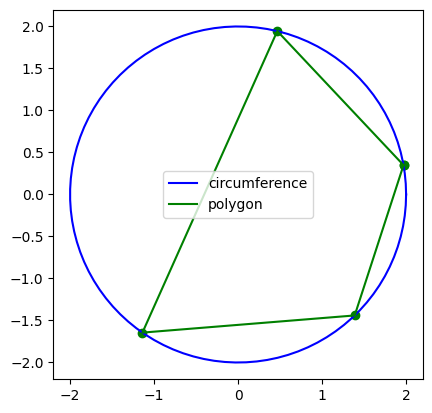

In [3]:
def visualize_ploygons(
        polygons, 
        visualize_points=True, 
        visualize_circumference=True, 
        polygon_color='green',
        circumference_color='blue',
        legend=True,
        path=None
    ):

    fig, ax = plt.subplots()

    for polygon in polygons:

        x = [point.x for point in polygon.points] + [polygon.points[0].x]
        y = [point.y for point in polygon.points] + [polygon.points[0].y]

        # Plot the circumference
        if visualize_circumference:

            r = Point(0, 0).distance(polygon.points[0])
            theta = np.linspace(0, 2*np.pi, 100)

            # Compute x1 and x2
            x_c = r*np.cos(theta)
            y_c = r*np.sin(theta)

            ax.plot(x_c, y_c, color=circumference_color, label='circumference')

        # Plot the polygon
        ax.plot(x, y, color=polygon_color, label='polygon')

        # Scatter the points
        if visualize_points:
            ax.scatter(x, y, color=polygon_color)

    if legend:
        ax.legend()
    
    ax.set_aspect(1)

    if path is not None:
        plt.savefig(path)
    
    plt.show()

p = Polygon.generate_random_polygon(5, 2, merge_near_points=2)
visualize_ploygons([p])


In [4]:
for point in p.points:
    
    r = Point(0, 0).distance(point)
    theta = np.rad2deg(np.arctan2(point.y, point.x))
    
    print(f'Point({point.x}, {point.y}) at angle {theta % 360}')


Point(1.969293384801813, 0.3491182673189967) at angle 10.053003439704474
Point(0.4666086598522916, 1.944807537663007) at angle 76.50831011749486
Point(-1.1386308640793779, -1.6442383511419048) at angle 235.29749746669037
Point(1.3880545932042005, -1.4398973735251832) at angle 313.9497559154149


# Test polygon intersection

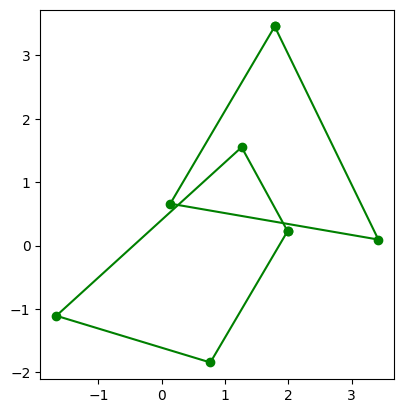

Intersecting: True


In [5]:
p1 = Polygon.generate_random_polygon(5, 2, merge_near_points=1)
p2 = Polygon.generate_random_polygon(5, 2, merge_near_points=1)

p2.translate(random.random() * 3, random.random() * 3)

visualize_ploygons([p1, p2], visualize_circumference=False, legend=False)
print(f'Intersecting: {p1.intersects(p2)}')

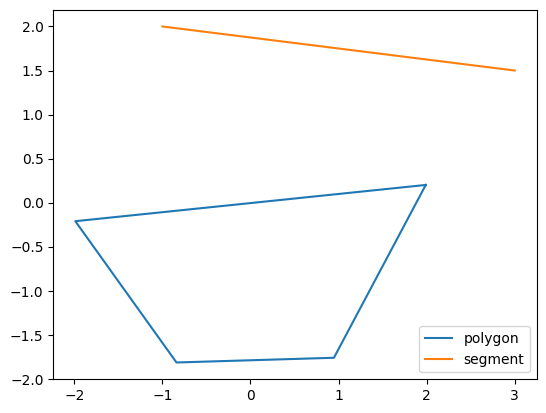

Intersecting: False


In [35]:
p1 = Polygon.generate_random_polygon(5, 2, merge_near_points=1)
s1 = Segment(Point(-1, 2), Point(3, 1.5))

p1_x = [p.x for p in p1.points] + [p1.points[0].x]
p1_y = [p.y for p in p1.points] + [p1.points[0].y]

s1_x = [s1.start.x, s1.end.x]
s1_y = [s1.start.y, s1.end.y]

fig, ax = plt.subplots()

# Plot the polygon
ax.plot(p1_x, p1_y, label='polygon')

# Plot the segment
ax.plot(s1_x, s1_y, label='segment')

ax.legend()
ax.set_aspect(1)
plt.show()

print(f'Intersecting: {p1.intersects(s1)}')

# Test map generation

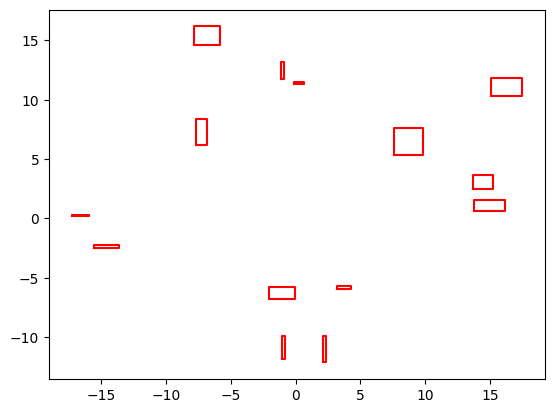

In [7]:
# Math
from math import pi, sin, cos
import random

# Serialization
import pickle
import json


# random environment parameters
OBS_MIN_DIM = 0.1  # meters
OBS_MAX_DIM = 2.5  # meters
OBS_MIN_COUNT = 10
OBS_MAX_COUNT = 50
OBS_MIN_DIST = 2.0  # meters
OBS_MAX_DIST = 20.0  # meters
GOAL_MIN_DIST = 2.0  # meters
GOAL_MAX_DIST = 4.0  # meters
MIN_GOAL_CLEARANCE = 0.2  # meters


class Rectangle(Polygon):

    def __init__(self, width, height):

        if width <= 0:
            raise ValueError(f'Invalid width: {width}')

        if height <= 0:
            raise ValueError(f'Invalid height: {height}')

        points = [
            Point(0, 0),
            Point(0, height),
            Point(width, height),
            Point(width, 0)
        ]

        super().__init__(points)

class Map:

    def __init__(self):

        # Initial obstacle position
        self.obstacles = []

        # Current obstacle position
        self.current_obstacles = []

        self.current_goal = None

    def random_map(self, robots):

        # Obstacle parameters
        obs_min_dim = OBS_MIN_DIM
        obs_max_dim = OBS_MAX_DIM
        obs_min_count = OBS_MIN_COUNT
        obs_max_count = OBS_MAX_COUNT
        obs_min_dist = OBS_MIN_DIST
        obs_max_dist = OBS_MAX_DIST

        # Goal parameters
        goal_min_dist = GOAL_MIN_DIST
        goal_max_dist = GOAL_MAX_DIST

        # Generate the goal
        goal_dist_range = goal_max_dist - goal_min_dist
        dist = goal_min_dist + (random.random() * goal_dist_range)
        phi = -pi + (random.random() * 2 * pi)
        x = dist * sin(phi)
        y = dist * cos(phi)
        goal = Point(x, y)

        # Generate a proximity test geometry for the goal
        r = MIN_GOAL_CLEARANCE
        n = 6
        goal_test_geometry = []
        for i in range(n):
            goal_test_geometry.append(
                Point(x + r * cos(i * 2 * pi / n), y + r * sin(i * 2 * pi / n))
            )
        goal_test_geometry = Polygon(goal_test_geometry)

        # Generate the obstacles
        obstacles = []
        obs_dim_range = obs_max_dim - obs_min_dim
        obs_dist_range = obs_max_dist - obs_min_dist
        num_obstacles = random.randrange(obs_min_count, obs_max_count + 1)

        # test_geometries contains the robots and the goal
        test_geometries = [r.body for r in robots] + [
            goal_test_geometry
        ]

        while len(obstacles) < num_obstacles:

            # Generate dimensions
            width = obs_min_dim + (random.random() * obs_dim_range)
            height = obs_min_dim + (random.random() * obs_dim_range)

            # Generate position
            dist = obs_min_dist + (random.random() * obs_dist_range)
            phi = -pi + (random.random() * 2 * pi)
            x = dist * sin(phi)
            y = dist * cos(phi)

            # Generate orientation
            theta = -pi + (random.random() * 2 * pi)

            # We have a pose
            pose = (x, y, theta)

            # Create a polygon
            polygon = Rectangle(width, height)
            polygon.translate(x, y)

            # Check if the polygon intersects one of the test geometries
            intersects = False
            for test_geometry in test_geometries:
                intersects |= polygon.intersects(test_geometry)
                if intersects:
                    break

            # The polygon is good: add the velocity vector and create an obstacle 
            if not intersects:

                obstacles.append(polygon)

        # Update the obstacles and the goal
        self.current_obstacles = obstacles
        self.obstacles = obstacles
        self.current_goal = goal

    def reset_map(self):
        self.current_obstacles = self.obstacles

    def save_map(self, filename):
        with open(filename, "wb") as file:
            pickle.dump(self.current_obstacles, file)
            pickle.dump(self.current_goal, file)

    def load_map(self, filename):
        with open(filename, "rb") as file:
            self.current_obstacles = pickle.load(file)
            self.current_goal = pickle.load(file)


map = Map()
map.random_map([])

# Visualize the map

fig, ax = plt.subplots()

for polygon in map.obstacles:

    x = [point.x for point in polygon.points] + [polygon.points[0].x]
    y = [point.y for point in polygon.points] + [polygon.points[0].y]

    # Plot the polygon
    ax.plot(x, y, color='red', label='polygon')

plt.show()
    

# Test translation and rotation

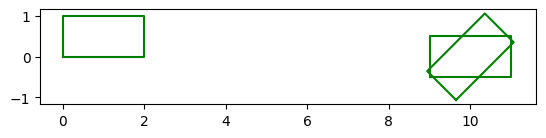

In [8]:
polygon_1 = Rectangle(2, 1)
polygon_2 = polygon_1.copy()
polygon_3 = polygon_1.copy()

pose_2 = (10, 0, 0)
polygon_2.transform_to(pose_2)

pose_3 = (10, 0, 45)
polygon_3.transform_to(pose_3)

# Plot the polygons
fig, ax = plt.subplots()

# Gather the points
x_1 = [point.x for point in polygon_1.points] + [polygon_1.points[0].x]
y_1 = [point.y for point in polygon_1.points] + [polygon_1.points[0].y]

x_2 = [point.x for point in polygon_2.points] + [polygon_2.points[0].x]
y_2 = [point.y for point in polygon_2.points] + [polygon_2.points[0].y]

x_3 = [point.x for point in polygon_3.points] + [polygon_3.points[0].x]
y_3 = [point.y for point in polygon_3.points] + [polygon_3.points[0].y]

# Plot the polygon
ax.plot(x_1, y_1, color='green', label='polygon')
ax.plot(x_2, y_2, color='green', label='polygon')
ax.plot(x_3, y_3, color='green', label='polygon')

ax.set_aspect(1)

plt.show()

Angle: 0
Angle: 45
Angle: 90
Angle: 135
Angle: 180


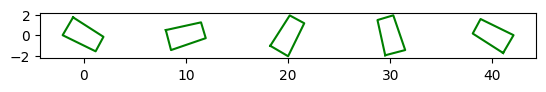

In [9]:
polygon = Polygon.generate_random_polygon(5, 2, merge_near_points=1)

x_offsets = [0, 10, 20, 30, 40]
angles = [0, 45, 90, 135, 180]

polygons = []
for x_offset, angle in zip(x_offsets, angles):
    polygon.transform_to((x_offset, 0, angle))
    print(f'Angle: {polygon.angle}')
    polygons.append(polygon.copy())

visualize_ploygons(polygons, visualize_circumference=False, visualize_points=False, legend=False)

Old vs new theta: 0 / 4.5 
Old vs new theta: 4.5 / 9.0 
Old vs new theta: 9.0 / 13.5 
Old vs new theta: 13.5 / 18.0 
Old vs new theta: 18.0 / 22.5 


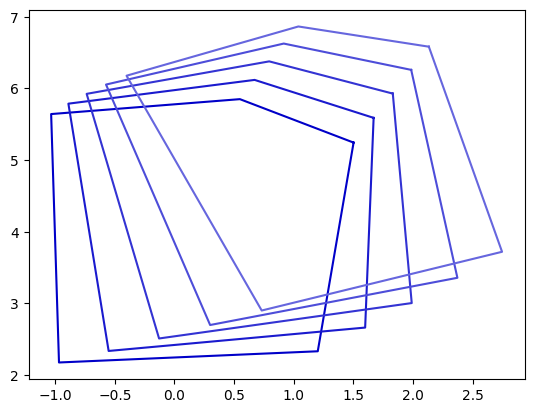

In [10]:

def lighter(color, percent):
    color = np.array(color)
    white = np.array([255, 255, 255])
    vector = white - color
    return color + vector * percent

pose = (0, 4, 0)
vel = (5, 5, 90)
dt = 0.05
polygon = Polygon.generate_random_polygon(5, 2, merge_near_points=1)

steps = 5
polygon_transformations = []
for _ in range(steps):

    x, y, theta = pose
    vx, vy, va = vel

    new_x = x + vx * dt
    new_y = y + vy * dt
    new_theta = (theta + va * dt) % 360
    print(f'Old vs new theta: {theta} / {new_theta} ')

    pose = (new_x, new_y, new_theta)
    polygon.transform_to(pose)
    
    polygon_transformations.append(polygon.copy())


fig, ax = plt.subplots()

for i, polygon in enumerate(polygon_transformations):

    x = [point.x for point in polygon.points] + [polygon.points[0].x]
    y = [point.y for point in polygon.points] + [polygon.points[0].y]

    color = lighter([0, 0, 200], i / 10)

    plt.plot(x, y, color=(color[0] / 255, color[1] / 255, color[2] / 255))

plt.show()